# **Stylized effects in synthetic returns**

[link to paper](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf)

In [1]:
import tensorflow as tf
# filter out retracing warnings
tf.get_logger().setLevel('ERROR')
import numpy as np

# try to obtain reproducible results
tf.random.set_seed(0)
np.random.seed(0)

In [2]:
from google.colab import drive
import sys
drive.mount("/content/gdrive", force_remount=True)
sys.path.append('/content/gdrive/My Drive/THESIS')
!pip install tensorflow-addons

Mounted at /content/gdrive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.random import normal
from backend.preprocessing import *
from backend.metrics import *

from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest

In [4]:
df = pd.read_csv('gdrive/My Drive/THESIS/datasets/sp500.csv').set_index('Date')
log_returns = np.log(df/df.shift(1))[1:].to_numpy()

# Set up preprocessing pipeline

In [5]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

s2.fit(g1.fit_transform(s1.fit_transform(log_returns)));

In [6]:
generator = load_model('/content/gdrive/My Drive/THESIS/trained_generator')
rfs = 127

# Generating synthetic returns

In [7]:
# Filter out paths with a maximum/minimum return filter_constant times that of 
# the maximum/minimum return of the original distribution
filter_constant = 2
n_samples = 1000
length = len(log_returns)

noise = normal([n_samples, 1, length + rfs - 1, 3])
y = generator(noise).numpy().squeeze()

y = (y - y.mean())/y.std()
y = s2.inverse_transform(y)
y = g1.inverse_transform(np.expand_dims(y.flatten(), 1)).reshape(n_samples, length)
y = s1.inverse_transform(y);
y = y[(y.max(axis=1) <= filter_constant * log_returns.max()) & (y.min(axis=1) >= filter_constant * log_returns.min())]

# Compare real vs. synthetic distributions

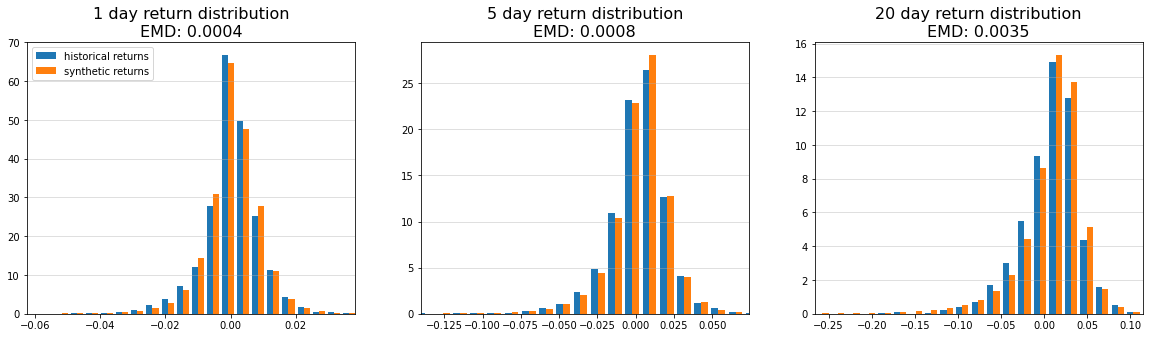

In [8]:
n_bins = 50
windows = [1, 5, 20]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))


for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    ax[i].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    ax[i].set_title('{} day return distribution\nEMD: {:.4f}'.format(windows[i], wasserstein_distance(real_dist, fake_dist)), size=16)
    ax[i].yaxis.grid(True, alpha=0.5)

ax[0].legend(['historical returns', 'synthetic returns']);

## Aggregational Gaussianity

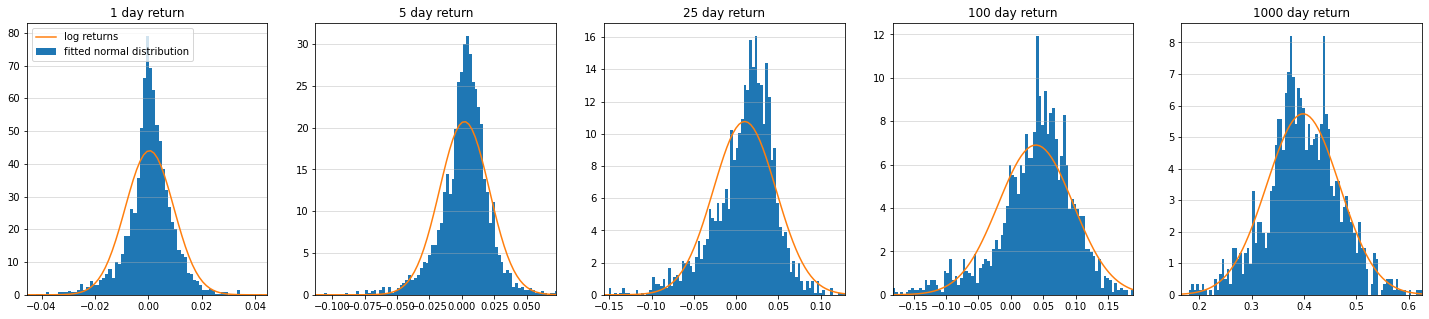

In [9]:
windows = [1, 5, 25, 100, 1000]
n_bins = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(real_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), n_bins)
    ax[i].plot(x_range, norm.pdf(x_range, real_dist.mean(), real_dist.std()))
    ax[i].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    ax[i].set_title('{} day return'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)

ax[0].legend(['log returns', 'fitted normal distribution'], loc='upper left');

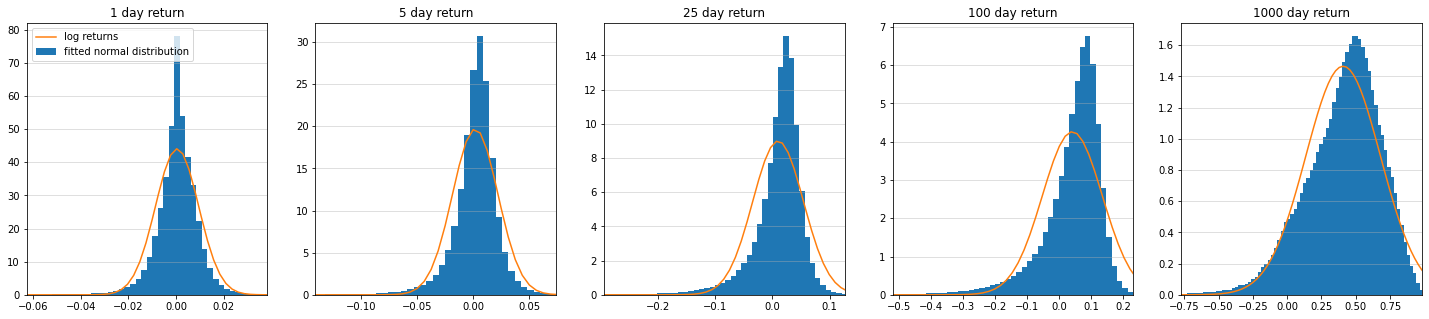

In [10]:
windows = [1, 5, 25, 100, 1000]
n_bins = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))

for i in range(len(windows)):
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(fake_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), n_bins)
    ax[i].plot(x_range, norm.pdf(x_range, fake_dist.mean(), fake_dist.std()))
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    ax[i].set_title('{} day return'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)

ax[0].legend(['log returns', 'fitted normal distribution'], loc='upper left');

In [11]:
windows = [1, 5, 20, 100, 1000]

stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).squeeze()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['Skewness', 'Skewness p-value', 'Kurtosis', 'Kurtosis p-value'], index=pd.Series(windows, name='Window size'))
stats_df.rownames = windows

stats_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


,Skewness,Skewness p-value,Kurtosis,Kurtosis p-value
Window size,,,,
1,-0.555,0.000,5.061,0.000
5,-0.907,0.000,4.639,0.000
20,-0.917,0.000,2.550,0.000
100,-0.785,0.000,1.239,0.000
1000,-0.078,0.256,0.533,0.001


In [12]:
windows = [1, 5, 20, 100, 1000]

stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['Skewness', 'Skewness p-value', 'Kurtosis', 'Kurtosis p-value'], index=pd.Series(windows, name='Window size'))
stats_df.rownames = windows

stats_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


,Skewness,Skewness p-value,Kurtosis,Kurtosis p-value
Window size,,,,
1,-1.370,0.0,13.421,0.0
5,-1.772,0.0,11.965,0.0
20,-2.202,0.0,10.949,0.0
100,-1.918,0.0,6.727,0.0
1000,-0.719,0.0,0.888,0.0


# Gain/loss assymetry

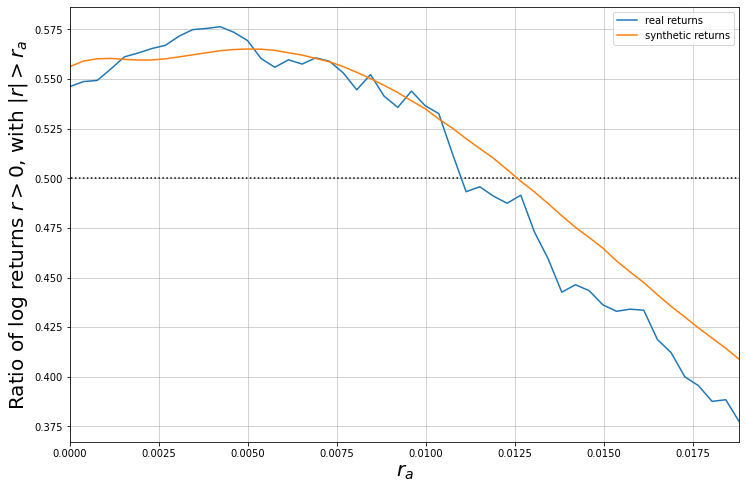

In [13]:
real_dist = log_returns.squeeze()
fake_dist = y.ravel() 

loss_assymetry = lambda dist, x: np.mean((dist[np.abs(dist) > x] >= 0))

fig, ax = plt.subplots(figsize=(12,8))
x_range = np.linspace(0, np.quantile(np.abs(real_dist), .95), 50)
ax.plot(x_range, [loss_assymetry(real_dist, x) for x in x_range], label='real returns')
ax.plot(x_range, [loss_assymetry(fake_dist, x) for x in x_range], label='synthetic returns')
ax.hlines(0.5, -1, 1, linestyles='dotted');
ax.set_xlim(0, np.quantile(np.abs(real_dist), .95))

ax.set_xlabel('$r_a$', size=20)
ax.set_ylabel('Ratio of log returns $r > 0$, with $|r| > r_a$', size=20)

ax.grid(alpha=0.7)

ax.legend();

# Intermittency

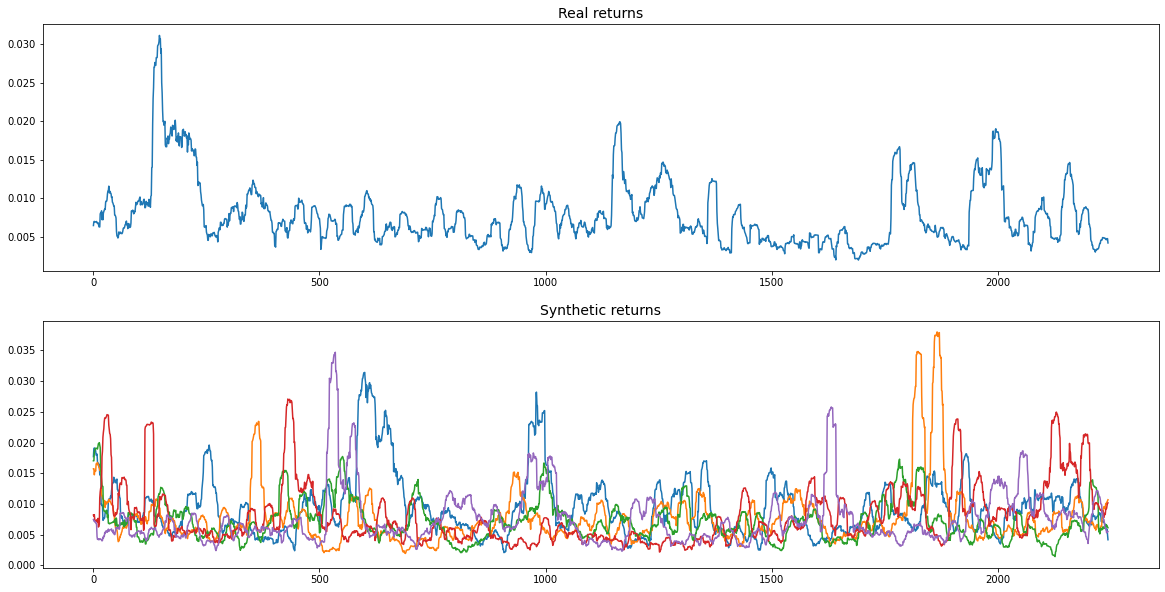

In [14]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
ax[0].plot(rolling_window(log_returns, 20).std(axis=0))
ax[0].set_title('Real returns', size=14)
ax[1].plot(rolling_window(y[:5].T, 20).std(axis=0))
ax[1].set_title('Synthetic returns', size=14);

# Volatility clustering

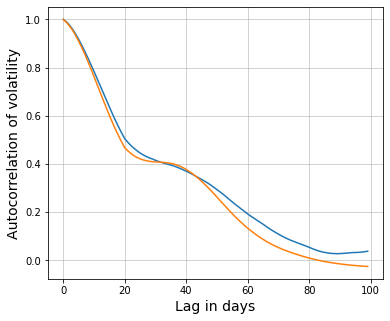

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(acf(rolling_window(log_returns, 20).std(axis=0), 100));
ax.plot(acf(rolling_window(y.T, 20).std(axis=0), 100).mean(axis=1))
ax.grid(alpha=0.7)

ax.set_xlabel('Lag in days', size=14)
ax.set_ylabel('Autocorrelation of volatility', size=14);

# Tail index

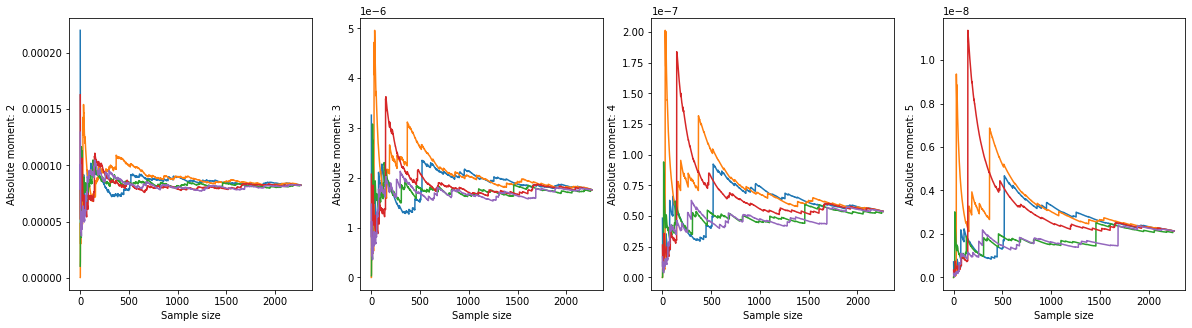

In [16]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: underflow encountered in power
  # Remove the CWD from sys.path while we load stuff.


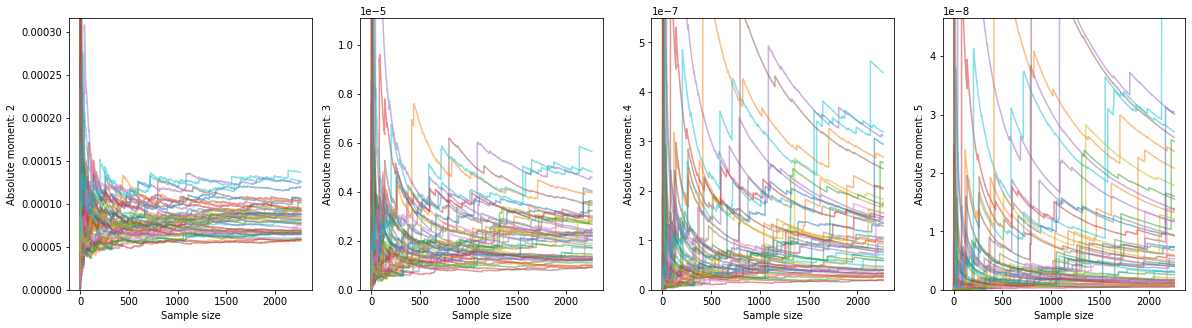

In [17]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]));

# Note the underflow error, some values when raised to a high power produce
# values so small that they fall outside of the range of float32, 
# this is not a big deal

# Autocorrelation effects

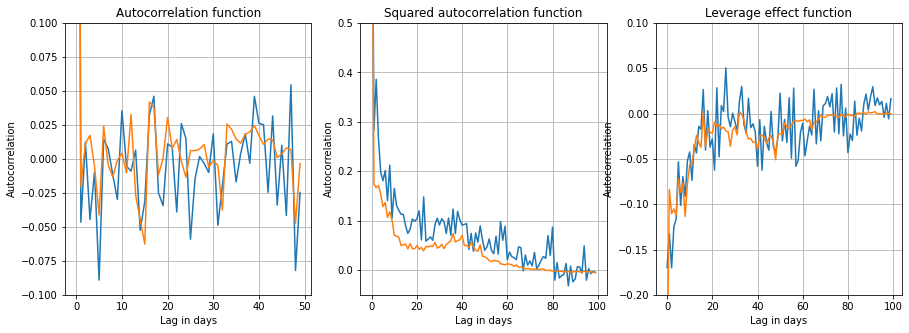

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

axs[0].plot(acf(log_returns, 50))
axs[0].plot(acf(y.T, 50).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_title('Autocorrelation function')
axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].plot(acf(y.T**2, 100).mean(axis=1))
axs[1].set_title('Squared autocorrelation function')
axs[2].plot(acf(log_returns, 100, le=True))
axs[2].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[2].set_ylim(-0.2, 0.1)
axs[2].set_title('Leverage effect function')


for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='Lag in days', ylabel='Autocorrelation');